# Ноутбук с решением финального проекта модуля

In [1]:
import causalml.metrics as cmetrics
import causalml.inference.tree as ctree
import causalml.inference.meta.rlearner as rlearner
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [6]:
FEATURES_DATE_TO = 102
TEST_DATE_TO = 250
CAMPAIGN_DURATION = 30
PRICE = 80
COST_PRICE = 52
COMMUNICATION_COST = 1
MARGIN_RATE = (PRICE-COST_PRICE)/PRICE


def compute_receipts_features(
    receipts: pd.DataFrame,
    date_to: int,
    num_days: int,
) -> pd.DataFrame:
    date_from = date_to - num_days
    date_mask = (receipts['date'] >= date_from) & (receipts['date'] < date_to)
    
    features = (
        receipts
        .loc[date_mask]
        .groupby(by=['customer_id'])
        .agg({
            "purchase_amt": ["count", "sum", "max", "min", "mean", "median"],
            "purchase_sum": ["sum", "max", "min", "mean", "median"],
            "date": ["min", "max"],
            "discount": ["sum"]
        })
        .assign(
            mean_time_interval=lambda d: (
                (d['date']['max'] - d['date']['min'])
                / (d['purchase_amt']['count'] - 1)
            )
        )
        .assign(
            time_since_last=lambda d: (
                date_to - d['date']['max']
            )
        )
        .assign(
            lifetime=lambda d: (
                date_to - d['date']['min']
            )
        )
        .assign(
            lifetime_purchase_sum=lambda d: (
                (d['date']['max'] - d['date']['min'])
                / (d['purchase_sum']['sum'] - 1)
            )
        )
        .assign(
            lifetime_purchase_amt=lambda d: (
                (d['date']['max'] - d['date']['min'])
                / (d['purchase_amt']['sum'] - 1)
            )
        )
    )

    column_names = [
        f'{col}__{agg}__{num_days}d' if agg else f'{col}__{num_days}d'
        for col, agg in features.columns
    ]
    features.columns = column_names
    features.reset_index(inplace=True)

    return features


def _prepare_data(
    receipts: pd.DataFrame,
    campaign_results: pd.DataFrame,
    customers: pd.DataFrame,
    features_date_to: int = FEATURES_DATE_TO
) -> pd.DataFrame:

    result_parts = [
        compute_receipts_features(receipts, features_date_to, num_days=7),
        compute_receipts_features(receipts, features_date_to, num_days=14),
        compute_receipts_features(receipts, features_date_to, num_days=60),
        compute_receipts_features(receipts, features_date_to, num_days=90),
        customers,
    ]

    result = campaign_results.copy()
    for part in result_parts:
        result = result.merge(part, on='customer_id', how='left')

    return result


def _prepare_test_data(
    receipts: pd.DataFrame,
    customers: pd.DataFrame,
    features_date_to: int = FEATURES_DATE_TO
) -> pd.DataFrame:

    result_parts = [
        customers,
        compute_receipts_features(receipts, features_date_to, num_days=7),
        compute_receipts_features(receipts, features_date_to, num_days=14),
        compute_receipts_features(receipts, features_date_to, num_days=60),
        compute_receipts_features(receipts, features_date_to, num_days=90),
    ]

    result = result_parts[0]
    for part in result_parts[1:]:
        result = result.merge(part, on='customer_id', how='left')

    return result

## Load'n'cook

In [7]:
campaigns = pd.read_csv('./data/campaigns.csv').drop(columns='Unnamed: 0')
customers = pd.read_csv('./data/customers.csv').drop(columns='Unnamed: 0')
receipts = pd.read_parquet('./data/receipts.parquet')

### first glance

In [8]:
receipts.head()

,customer_id,date,purchase_amt,discount,purchase_sum
26,26,0,12.125273,0,970.021866
53,53,0,34.357035,0,2748.562788
56,56,0,8.695825,0,695.666022
58,58,0,28.299046,0,2263.923641
64,64,0,32.547511,0,2603.800857


In [9]:
campaigns.date.unique()

array([102])

In [10]:
all_customers = set(customers.customer_id.unique())
target_customers = set(campaigns.customer_id.unique())
not_target_customers = all_customers.difference(target_customers)
control_customers = set(np.random.choice(list(not_target_customers), size=len(target_customers), replace=False))

print(len(all_customers))

2000000


### cook

#### campaign period

In [11]:
target_cols = ['target_purchases_count', 'target_purchases_sum', 'target_campaign_points_spent', 'target_purchases_amt_sum']

In [12]:
campaign_results = (
    compute_receipts_features(receipts, 102+CAMPAIGN_DURATION, num_days=CAMPAIGN_DURATION)
    .rename(columns={
        f'purchase_amt__count__{CAMPAIGN_DURATION}d': 'target_purchases_count',
        f'purchase_amt__sum__{CAMPAIGN_DURATION}d': 'target_purchases_amt_sum',
        f'purchase_sum__sum__{CAMPAIGN_DURATION}d': 'target_purchases_sum',
        f'discount__sum__{CAMPAIGN_DURATION}d': 'target_campaign_points_spent',
    })
    [['customer_id']+target_cols]
    .merge(customers[['customer_id']], how='right')
    .fillna(0)
)

campaign_results['treatment_flg'] = 0
campaign_results.loc[campaign_results.customer_id.isin(target_customers), 'treatment_flg'] = 1

campaign_results.shape

(2000000, 6)

#### first features portion

In [14]:
campaign_results = _prepare_data(
    receipts,
    campaign_results,
    customers,
)

#### profit from client

In [16]:
campaign_results = campaign_results.assign(target_profit=lambda d: (
    d['target_purchases_sum'] - d['target_purchases_amt_sum'] * COST_PRICE
    - d['target_campaign_points_spent']
    - (d['treatment_flg'] == 1).astype(int) * COMMUNICATION_COST
))

In [17]:
_columns = [
    'treatment_flg',
    'target_profit',
    'target_purchases_sum',
    'target_purchases_count',
    'target_campaign_points_spent'
]

campaign_results[_columns].head()

,treatment_flg,target_profit,target_purchases_sum,target_purchases_count,target_campaign_points_spent
0,1,847.568339,2538.766684,3.0,40.0
1,1,881.030697,2520.087704,3.0,0.0
2,1,1468.691792,4199.119407,2.0,0.0
3,1,2609.562982,7573.037092,4.0,40.0
4,1,360.654491,1033.298545,1.0,0.0


### splits

In [18]:
fit_index, val_index = train_test_split(campaign_results.index, test_size=0.5, random_state=165)

### column sets

In [19]:
cols_features_n1 = [
    'purchase_amt__count__7d',
    'purchase_amt__sum__7d',
    'purchase_amt__max__7d',
    'purchase_amt__min__7d',
    'purchase_amt__mean__7d',
    'purchase_amt__median__7d',
    'purchase_sum__sum__7d',
    'purchase_sum__max__7d',
    'purchase_sum__min__7d',
    'purchase_sum__mean__7d',
    'purchase_sum__median__7d',
    'date__min__7d',
    'date__max__7d',
    'mean_time_interval__7d',
    'time_since_last__7d',
    'lifetime__7d',
    'lifetime_purchase_sum__7d',
    'lifetime_purchase_amt__7d',
    'purchase_amt__count__14d',
    'purchase_amt__sum__14d',
    'purchase_amt__max__14d',
    'purchase_amt__min__14d',
    'purchase_amt__mean__14d',
    'purchase_amt__median__14d',
    'purchase_sum__sum__14d',
    'purchase_sum__max__14d',
    'purchase_sum__min__14d',
    'purchase_sum__mean__14d',
    'purchase_sum__median__14d',
    'date__min__14d',
    'date__max__14d',
    'mean_time_interval__14d',
    'time_since_last__14d',
    'lifetime__14d',
    'lifetime_purchase_sum__14d',
    'lifetime_purchase_amt__14d',
    'purchase_amt__count__60d',
    'purchase_amt__sum__60d',
    'purchase_amt__max__60d',
    'purchase_amt__min__60d',
    'purchase_amt__mean__60d',
    'purchase_amt__median__60d',
    'purchase_sum__sum__60d',
    'purchase_sum__max__60d',
    'purchase_sum__min__60d',
    'purchase_sum__mean__60d',
    'purchase_sum__median__60d',
    'date__min__60d',
    'date__max__60d',
    'mean_time_interval__60d',
    'time_since_last__60d',
    'lifetime__60d',
    'lifetime_purchase_sum__60d',
    'lifetime_purchase_amt__60d',
    'purchase_amt__count__90d',
    'purchase_amt__sum__90d',
    'purchase_amt__max__90d',
    'purchase_amt__min__90d',
    'purchase_amt__mean__90d',
    'purchase_amt__median__90d',
    'purchase_sum__sum__90d',
    'purchase_sum__max__90d',
    'purchase_sum__min__90d',
    'purchase_sum__mean__90d',
    'purchase_sum__median__90d',
    'date__min__90d',
    'date__max__90d',
    'mean_time_interval__90d',
    'time_since_last__90d',
    'lifetime__90d',
    'lifetime_purchase_sum__90d',
    'lifetime_purchase_amt__90d',
    'age',
]

## Rlearner

In [20]:
col_target = 'target_profit'
col_treatment = 'treatment_flg'

In [21]:
cols_features = cols_features_n1

In [22]:
model_n1 = rlearner.BaseRRegressor(
    learner=lgb.LGBMRegressor(),
    control_name=0,
    n_fold=4,
    random_state=165
)

In [23]:
_p_score_const = campaign_results.loc[fit_index, col_treatment].value_counts(normalize=True).loc[1]
print(_p_score_const)
_p_scores = pd.Series(data=_p_score_const, index=fit_index)
model_n1.fit(
    X=campaign_results.loc[fit_index, cols_features].values,
    treatment=campaign_results.loc[fit_index, col_treatment].values,
    y=campaign_results.loc[fit_index, col_target].values,
    p=_p_scores
)

0.25007


#### evaluate model

In [24]:
_eval_data = campaign_results.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = model_n1.predict(_eval_data[cols_features])
_eval_data = _eval_data[['score', col_treatment, col_target]]

In [25]:
low=np.percentile(_eval_data['score'], 3)

In [26]:
high=np.percentile(_eval_data['score'], 97)

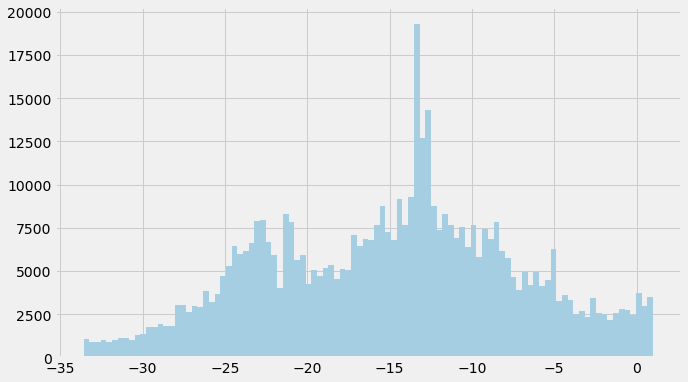

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(_eval_data['score'], range=(np.percentile(_eval_data['score'], 5), 1), bins=100)
plt.show()

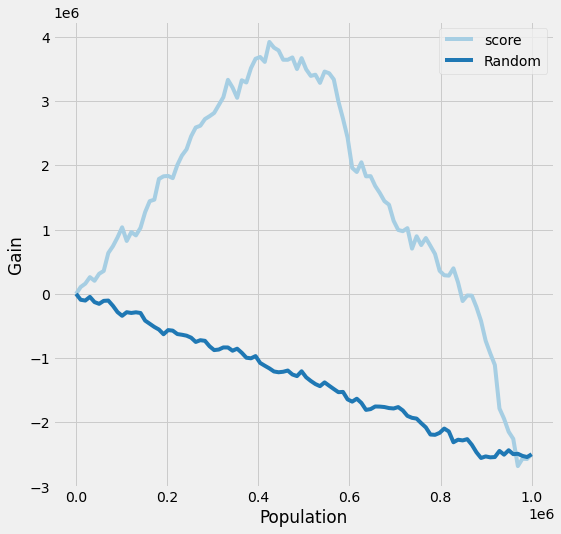

In [28]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

In [29]:
N_USERS_OPTIM = 420000

In [30]:
_p_score_const = campaign_results.loc[:, col_treatment].value_counts(normalize=True).loc[1]
print(_p_score_const)
_p_scores = pd.Series(data=_p_score_const, index=campaign_results.index)

model_n1.fit(
    X=campaign_results.loc[:, cols_features].values,
    treatment=campaign_results.loc[:, col_treatment].values,
    y=campaign_results.loc[:, col_target].values,
    p=_p_scores
)

0.25


## RandomForest

In [47]:
upmodel_rf = ctree.UpliftRandomForestClassifier(
    control_name='control',
    evaluationFunction='DDP',
    n_estimators=10,
    max_features=40,
    max_depth=6,
    min_samples_leaf=100
)

In [48]:
%%time 


upmodel_rf.fit(
    X=campaign_results.loc[fit_index, cols_features].fillna(0).values,
    treatment=campaign_results.loc[fit_index, col_treatment].apply(lambda t: 'treatment' if t == 1 else 'control').values,
    y=campaign_results.loc[fit_index, col_target].values,
)

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt


CPU times: user 56min 27s, sys: 2h 28min 22s, total: 3h 24min 50s
Wall time: 1h 18min 17s


In [49]:
_eval_data = campaign_results.loc[val_index, cols_features + [col_treatment, col_target]]
_eval_data['score'] = upmodel_rf.predict(_eval_data[cols_features].fillna(0).values)
_eval_data = _eval_data[['score', col_treatment, col_target]]

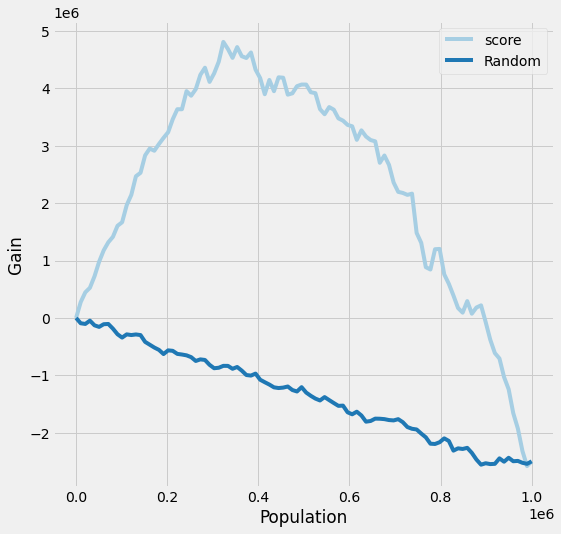

In [50]:
cmetrics.plot_gain(
    _eval_data,
    treatment_col=col_treatment,
    outcome_col=col_target,
)

## Inference 

In [52]:
df_test = _prepare_test_data(
    receipts,
    customers,
    TEST_DATE_TO,
)

df_test.shape

(2000000, 79)

In [ ]:
# RandomForest
df_test['score'] = upmodel_rf.predict(df_test[cols_features].fillna(0)).reshape(-1)

In [92]:
# R-learner
df_test['score'] = model_n1.predict(df_test[cols_features]).reshape(-1)

In [88]:
df_test = df_test.sort_values(by='score', ascending=False).iloc[:N_USERS_OPTIM][['customer_id']]

In [66]:
# df_test.to_csv('./data/submit.csv', index=False)